In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import json
from os.path import expanduser
import sqlite3
import seaborn as sns

#### compare PASEF features that were identified and see whether 3DID also detected them

In [2]:
experiment_name = 'P3856'
run_name = 'P3856_YHE211_1_Slot1-1_1_5104'

EXPERIMENT_DIR = '/media/big-ssd/experiments/{}'.format(experiment_name)

RESULTS_DIR = '/media/big-ssd/results-P3856'
# IDENTS_PASEF_DIR = '{}/P3856-results-cs-true-fmdw-true-2021-05-20-02-44-34/identifications-pasef'.format(RESULTS_DIR)
IDENTS_PASEF_DIR = '{}/identifications-pasef'.format(EXPERIMENT_DIR)
IDENTS_PASEF_FILE = '{}/exp-{}-identifications-pasef-recalibrated.pkl'.format(IDENTS_PASEF_DIR, experiment_name)

# FEATURES_PASEF_DIR = '{}/P3856-results-cs-true-fmdw-true-2021-05-20-02-44-34/features-pasef'.format(RESULTS_DIR)
FEATURES_PASEF_DIR = '{}/features-pasef'.format(EXPERIMENT_DIR)
FEATURES_PASEF_FILE = '{}/exp-{}-run-{}-features-pasef-dedup.pkl'.format(FEATURES_PASEF_DIR, experiment_name, run_name)

RESULTS_3DID_DIR = '/media/big-ssd/results-P3856-3did/minvi-2500'
FEATURES_3DID_DIR = '{}/features-3did'.format(RESULTS_3DID_DIR)
FEATURES_3DID_FILE = '{}/exp-{}-run-{}-features-3did-dedup.pkl'.format(FEATURES_3DID_DIR, experiment_name, run_name)

FEATURES_MQ_DIR = '{}/features-mq'.format(EXPERIMENT_DIR)
FEATURES_MQ_FILE = '{}/exp-{}-run-{}-features-mq-dedup.pkl'.format(FEATURES_MQ_DIR, experiment_name, run_name)

In [3]:
MAXIMUM_Q_VALUE = 0.01

In [4]:
# only look at this part of the run
RT_LOWER = 1650
RT_UPPER = 2200

In [5]:
# define a straight line to exclude the charge-1 cloud
def scan_coords_for_single_charge_region(mz_lower, mz_upper):
    scan_for_mz_lower = max(int(-1 * ((1.2 * mz_lower) - 1252)), 0)
    scan_for_mz_upper = max(int(-1 * ((1.2 * mz_upper) - 1252)), 0)
    return {'scan_for_mz_lower':scan_for_mz_lower, 'scan_for_mz_upper':scan_for_mz_upper}

In [6]:
# load the features identified by PASEF
with open(IDENTS_PASEF_FILE, 'rb') as handle:
    d = pickle.load(handle)
idents_pasef_df = d['identifications_df']
idents_pasef_df = idents_pasef_df[(idents_pasef_df.run_name == run_name) & (idents_pasef_df['percolator q-value'] <= MAXIMUM_Q_VALUE)].copy()
# idents_pasef_df = idents_pasef_df[(idents_pasef_df.mono_mz > mz_lower) & (idents_pasef_df.mono_mz < mz_upper) & (idents_pasef_df.scan_apex > scan_lower) & (idents_pasef_df.rt_apex > rt_lower) & (idents_pasef_df.rt_apex < rt_upper)]

In [7]:
idents_pasef_df['excluded'] = idents_pasef_df.apply(lambda row: row.scan_apex < scan_coords_for_single_charge_region(row.monoisotopic_mz, row.monoisotopic_mz)['scan_for_mz_lower'], axis=1)
idents_pasef_df = idents_pasef_df[(idents_pasef_df.excluded == False)]

In [8]:
# load the features detected by PASEF
with open(FEATURES_PASEF_FILE, 'rb') as handle:
    d = pickle.load(handle)
features_pasef_df = d['features_df']

In [9]:
features_pasef_df['excluded'] = features_pasef_df.apply(lambda row: row.scan_apex < scan_coords_for_single_charge_region(row.monoisotopic_mz, row.monoisotopic_mz)['scan_for_mz_lower'], axis=1)
features_pasef_df = features_pasef_df[(features_pasef_df.excluded == False)]

In [10]:
# load the features detected by 3DID
with open(FEATURES_3DID_FILE, 'rb') as handle:
    d = pickle.load(handle)
features_3did_df = d['features_df']

In [11]:
# load the features detected by MaxQuant
with open(FEATURES_MQ_FILE, 'rb') as handle:
    d = pickle.load(handle)
features_mq_df = d['features_df']

In [12]:
features_mq_df['excluded'] = features_mq_df.apply(lambda row: row.scan_apex < scan_coords_for_single_charge_region(row.monoisotopic_mz, row.monoisotopic_mz)['scan_for_mz_lower'], axis=1)
features_mq_df = features_mq_df[(features_mq_df.excluded == False)]
features_mq_df = features_mq_df[(features_mq_df.rt_apex >= RT_LOWER) & (features_mq_df.rt_apex <= RT_UPPER)]
features_mq_df = features_mq_df[(features_mq_df.isotope_count >= 3)].copy()

In [13]:
print('{} features from PASEF, {} features from MaxQuant, {} features from 3DID'.format(len(features_pasef_df), len(features_mq_df), len(features_3did_df)))


73312 features from PASEF, 15437 features from MaxQuant, 158249 features from 3DID


In [14]:
features_pasef_df.charge.value_counts()

2    54989
3     7937
1     7148
4     2153
5      669
6      287
8       70
7       59
Name: charge, dtype: int64

In [15]:
features_mq_df.charge.value_counts()

2    12852
3     2064
4      501
1       20
Name: charge, dtype: int64

In [16]:
features_3did_df.charge.value_counts()

2    123791
1     18267
3     13067
4      2036
5       822
6       182
7        49
8        35
Name: charge, dtype: int64

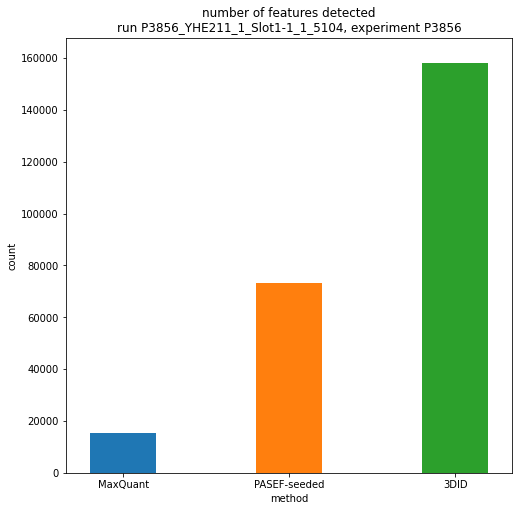

In [17]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(8)

plt.margins(0.06)
plt.title('')

barwidth = 0.4

ax1.bar('MaxQuant', len(features_mq_df), width=barwidth, align='center', log=False)
ax1.bar('PASEF-seeded', len(features_pasef_df), width=barwidth, align='center', log=False)
ax1.bar('3DID', len(features_3did_df), width=barwidth, align='center', log=False)

plt.xlabel('method')
plt.ylabel('count')
plt.title('number of features detected\nrun {}, experiment {}'.format(run_name, experiment_name))

plt.show()

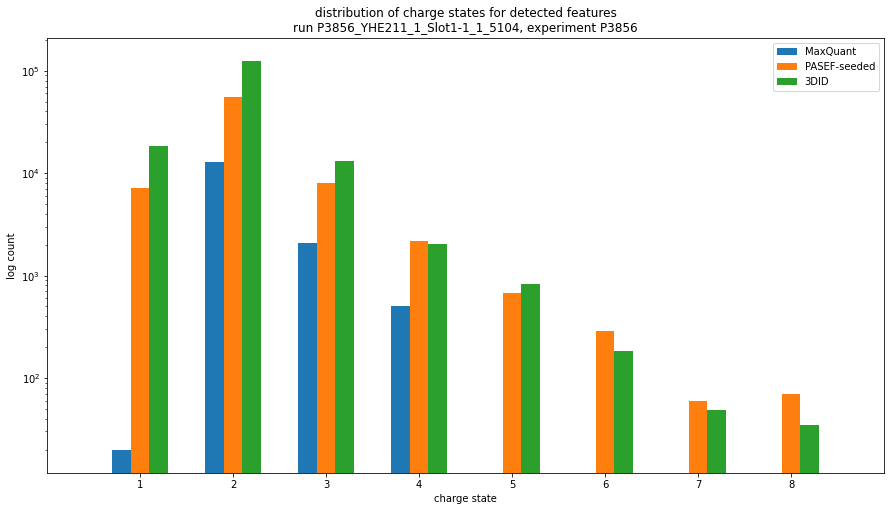

In [18]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

barwidth = 0.2
max_charge = max(features_pasef_df.charge.max(), features_mq_df.charge.max(), features_3did_df.charge.max())

pos1 = [x - barwidth for x in range(max_charge+1)]
pos2 = [x + barwidth for x in pos1]
pos3 = [x + (2*barwidth) for x in pos1]

counts = np.bincount(features_mq_df.charge, minlength=9)
ax1.bar(pos1, counts, width=barwidth, align='center', log=True, label='MaxQuant')

counts = np.bincount(features_pasef_df.charge, minlength=9)
ax1.bar(pos2, counts, width=barwidth, align='center', log=True, label='PASEF-seeded')

counts = np.bincount(features_3did_df.charge, minlength=9)
ax1.bar(pos3, counts, width=barwidth, align='center', log=True, label='3DID')

ax1.set(xticks=range(1,max_charge+1), xlim=[0, max_charge+1])

plt.xlabel('charge state')
plt.ylabel('log count')
plt.title('distribution of charge states for detected features\nrun {}, experiment {}'.format(run_name, experiment_name))

plt.legend()
plt.show()

#### find the features in common

In [19]:
DUP_MZ_TOLERANCE_PPM = 5
DUP_SCAN_TOLERANCE = 10
DUP_RT_TOLERANCE = 5

In [20]:
# set up dup definitions for 3DID
MZ_TOLERANCE_PERCENT = DUP_MZ_TOLERANCE_PPM * 10**-4
features_3did_df['dup_mz'] = features_3did_df['monoisotopic_mz']  # shorthand to reduce verbosity
features_3did_df['dup_mz_ppm_tolerance'] = features_3did_df.dup_mz * MZ_TOLERANCE_PERCENT / 100
features_3did_df['dup_mz_lower'] = features_3did_df.dup_mz - features_3did_df.dup_mz_ppm_tolerance
features_3did_df['dup_mz_upper'] = features_3did_df.dup_mz + features_3did_df.dup_mz_ppm_tolerance
features_3did_df['dup_scan_lower'] = features_3did_df.scan_apex - DUP_SCAN_TOLERANCE
features_3did_df['dup_scan_upper'] = features_3did_df.scan_apex + DUP_SCAN_TOLERANCE
features_3did_df['dup_rt_lower'] = features_3did_df.rt_apex - DUP_RT_TOLERANCE
features_3did_df['dup_rt_upper'] = features_3did_df.rt_apex + DUP_RT_TOLERANCE

In [21]:
# set up dup definitions for PASEF
MZ_TOLERANCE_PERCENT = DUP_MZ_TOLERANCE_PPM * 10**-4
idents_pasef_df['dup_mz'] = idents_pasef_df['monoisotopic_mz']  # shorthand to reduce verbosity
idents_pasef_df['dup_mz_ppm_tolerance'] = idents_pasef_df.dup_mz * MZ_TOLERANCE_PERCENT / 100
idents_pasef_df['dup_mz_lower'] = idents_pasef_df.dup_mz - idents_pasef_df.dup_mz_ppm_tolerance
idents_pasef_df['dup_mz_upper'] = idents_pasef_df.dup_mz + idents_pasef_df.dup_mz_ppm_tolerance
idents_pasef_df['dup_scan_lower'] = idents_pasef_df.scan_apex - DUP_SCAN_TOLERANCE
idents_pasef_df['dup_scan_upper'] = idents_pasef_df.scan_apex + DUP_SCAN_TOLERANCE
idents_pasef_df['dup_rt_lower'] = idents_pasef_df.rt_apex - DUP_RT_TOLERANCE
idents_pasef_df['dup_rt_upper'] = idents_pasef_df.rt_apex + DUP_RT_TOLERANCE

In [22]:
idents_pasef_df.sort_values(by=['deconvolution_score'], ascending=False, inplace=True)
features_3did_df.sort_values(by=['deconvolution_score'], ascending=False, inplace=True)

In [23]:
# find whether a feature detected by PASEF was also detected by 3DID
common_l = []
features_processed = set()
for row in idents_pasef_df.itertuples():
    if row.feature_id not in features_processed:
        df = features_3did_df[(row.charge == features_3did_df.charge) & (row.dup_mz >= features_3did_df.dup_mz_lower) & (row.dup_mz <= features_3did_df.dup_mz_upper) & (row.scan_apex >= features_3did_df.dup_scan_lower) & (row.scan_apex <= features_3did_df.dup_scan_upper) & (row.rt_apex >= features_3did_df.dup_rt_lower) & (row.rt_apex <= features_3did_df.dup_rt_upper)].copy()
        if len(df) > 0:
            common_l.append(
                {
                    'feature_id_pasef':row.feature_id, 
                    'deconv_score_pasef':row.deconvolution_score,
                    'feature_intensity_pasef':row.feature_intensity,
                    'feature_id_3did':df.iloc[0].feature_id, 
                    'deconv_score_3did':df.iloc[0].deconvolution_score,
                    'feature_intensity_3did':df.iloc[0].feature_intensity
                }
            )
            # record the features that have been processed
            features_processed.update(set(df.feature_id.tolist()))

common_pasef_3did_df = pd.DataFrame(common_l)

In [24]:
print('{} features in common'.format(len(common_pasef_3did_df)))

5819 features in common


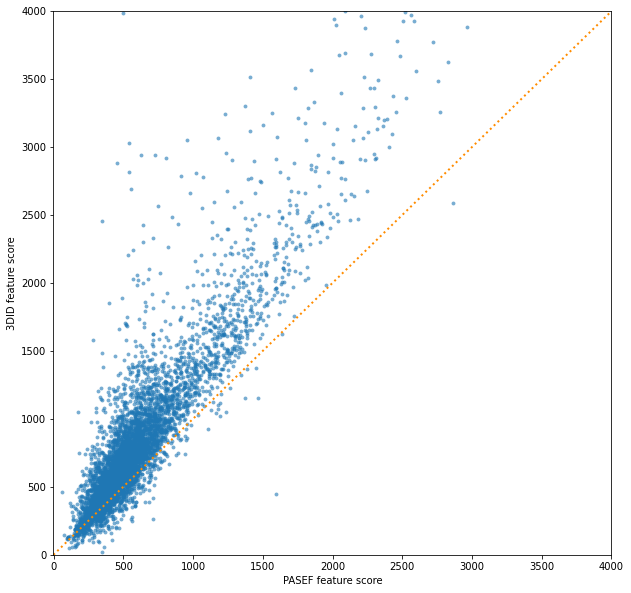

In [25]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(10)

plt.margins(0.06)
# plt.title('deconvolution score for features identified by PASEF-seeded and features detected by 3DID methods')

ax.scatter(common_pasef_3did_df.deconv_score_pasef, common_pasef_3did_df.deconv_score_3did, marker='o', lw=0, s=15, alpha=0.6)

ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle=':', linewidth=2, color='darkorange')

plt.xlim((-1,4000))
plt.ylim((-1,4000))

plt.xlabel('PASEF feature score')
plt.ylabel('3DID feature score')

plt.show()

#### visualise a feature detected and identified by PASEF but not by 3DID

In [26]:
# find the PASEF feature IDs that are not in the common set
feature_ids_not_found_by_3did_l = list(set(idents_pasef_df.feature_id.to_list()) - set(common_pasef_3did_df.feature_id_pasef.to_list()))


In [27]:
len(feature_ids_not_found_by_3did_l)

2850

In [28]:
import random

pasef_feature_not_detected = random.choice(feature_ids_not_found_by_3did_l)
pasef_feature_not_detected

2787501

In [29]:
idents_pasef_df[(idents_pasef_df.feature_id == pasef_feature_not_detected)]

,mono_mz_lower,mono_mz_upper,scan_apex,scan_lower,scan_upper,rt_apex,rt_lower,rt_upper,intensity_without_saturation_correction,intensity_with_saturation_correction,...,mass_error,excluded,dup_mz,dup_mz_ppm_tolerance,dup_mz_lower,dup_mz_upper,dup_scan_lower,dup_scan_upper,dup_rt_lower,dup_rt_upper
258,1009.947072,1010.011407,180.0,155,203,1951.599327,1947.364868,1960.065949,13400.0,13400.0,...,0.001028,False,1009.97924,0.00505,1009.97419,1009.984289,170.0,190.0,1946.599327,1956.599327


#### plot the intensities of features identified by PASEF but not detected by 3DID

In [30]:
idents_pasef_df['log_intensity'] = np.log10(idents_pasef_df.feature_intensity)

In [31]:
idents_pasef_df['not_detected_3did'] = idents_pasef_df.apply(lambda row: row.feature_id in feature_ids_not_found_by_3did_l, axis=1)

In [32]:
idents_not_detected_3did_df = idents_pasef_df[(idents_pasef_df.not_detected_3did == True)]

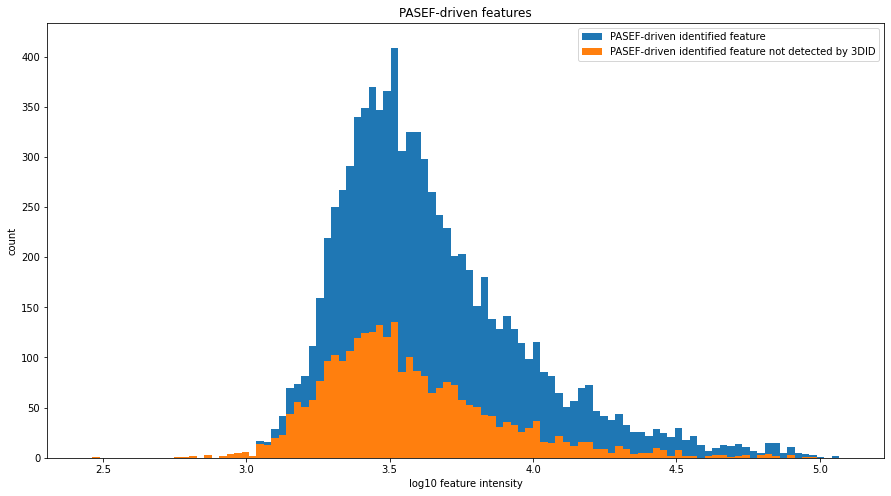

In [33]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('PASEF-driven features')

bins = 100
hist, bins, _ = plt.hist(idents_pasef_df.log_intensity, bins=bins, label='PASEF-driven identified feature')
hist, bins, _ = plt.hist(idents_not_detected_3did_df.log_intensity, bins=bins, label='PASEF-driven identified feature not detected by 3DID')

plt.xlabel('log10 feature intensity')
plt.ylabel('count')

# plt.xlim((-20,20))
# plt.ylim((0,300))

plt.legend()
plt.show()

#### plot the intensities of features identified by MaxQuant but not detected by 3DID

In [34]:
# set up dup definitions for MaxQuant
MZ_TOLERANCE_PERCENT = DUP_MZ_TOLERANCE_PPM * 10**-4
features_mq_df['dup_mz'] = features_mq_df['monoisotopic_mz']  # shorthand to reduce verbosity
features_mq_df['dup_mz_ppm_tolerance'] = features_mq_df.dup_mz * MZ_TOLERANCE_PERCENT / 100
features_mq_df['dup_mz_lower'] = features_mq_df.dup_mz - idents_pasef_df.dup_mz_ppm_tolerance
features_mq_df['dup_mz_upper'] = features_mq_df.dup_mz + idents_pasef_df.dup_mz_ppm_tolerance
features_mq_df['dup_scan_lower'] = features_mq_df.scan_apex - DUP_SCAN_TOLERANCE
features_mq_df['dup_scan_upper'] = features_mq_df.scan_apex + DUP_SCAN_TOLERANCE
features_mq_df['dup_rt_lower'] = features_mq_df.rt_apex - DUP_RT_TOLERANCE
features_mq_df['dup_rt_upper'] = features_mq_df.rt_apex + DUP_RT_TOLERANCE

In [35]:
# find whether a feature detected by MaxQuant was also detected by 3DID
common_l = []
features_processed = set()
for row in features_mq_df.itertuples():
    if row.feature_id not in features_processed:
        df = features_3did_df[(row.charge == features_3did_df.charge) & (row.dup_mz >= features_3did_df.dup_mz_lower) & (row.dup_mz <= features_3did_df.dup_mz_upper) & (row.scan_apex >= features_3did_df.dup_scan_lower) & (row.scan_apex <= features_3did_df.dup_scan_upper) & (row.rt_apex >= features_3did_df.dup_rt_lower) & (row.rt_apex <= features_3did_df.dup_rt_upper)].copy()
        if len(df) > 0:
            common_l.append(
                {
                    'feature_id_mq':row.feature_id, 
                    'feature_intensity_mq':row.intensity,
                    'feature_id_3did':df.iloc[0].feature_id, 
                    'deconv_score_3did':df.iloc[0].deconvolution_score,
                    'feature_intensity_3did':df.iloc[0].feature_intensity
                }
            )
            # record the features that have been processed
            features_processed.update(set(df.feature_id.tolist()))

common_mq_3did_df = pd.DataFrame(common_l)

In [36]:
print('{} features in common'.format(len(common_mq_3did_df)))

10534 features in common


In [37]:
# find the PASEF feature IDs that are not in the common set
feature_ids_not_found_by_3did_l = list(set(features_mq_df.feature_id.to_list()) - set(common_mq_3did_df.feature_id_mq.to_list()))


In [38]:
len(feature_ids_not_found_by_3did_l)

4903

In [39]:
features_mq_df['log_intensity'] = np.log10(features_mq_df.intensity)

In [40]:
features_mq_df['not_detected_3did'] = features_mq_df.apply(lambda row: row.feature_id in feature_ids_not_found_by_3did_l, axis=1)

In [41]:
idents_not_detected_3did_df = features_mq_df[(features_mq_df.not_detected_3did == True)]

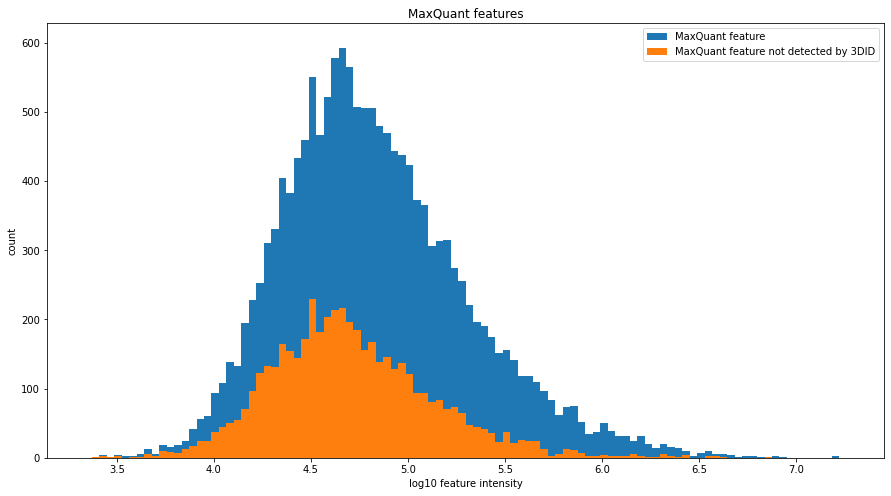

In [42]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('MaxQuant features')

bins = 100
hist, bins, _ = plt.hist(features_mq_df.log_intensity, bins=bins, label='MaxQuant feature')
hist, bins, _ = plt.hist(idents_not_detected_3did_df.log_intensity, bins=bins, label='MaxQuant feature not detected by 3DID')

plt.xlabel('log10 feature intensity')
plt.ylabel('count')

# plt.xlim((-20,20))
# plt.ylim((0,300))

plt.legend()
plt.show()

#### compare characteristics of detected features

In [43]:
features_mq_df['method'] = 'mq'
features_pasef_df['method'] = 'pasef'
features_3did_df['method'] = '3did'

In [44]:
features_mq_df['log_intensity'] = np.log10(features_mq_df.intensity)
features_pasef_df['log_intensity'] = np.log10(features_pasef_df.feature_intensity)
features_3did_df['log_intensity'] = np.log10(features_3did_df.feature_intensity)

In [45]:
features_mq_df['log_intensity_adjusted'] = features_mq_df.log_intensity - np.min(features_mq_df.log_intensity)
features_pasef_df['log_intensity_adjusted'] = features_pasef_df.log_intensity - np.min(features_pasef_df.log_intensity)
features_3did_df['log_intensity_adjusted'] = features_3did_df.log_intensity - np.min(features_3did_df.log_intensity)

In [46]:
intensities_l = [features_mq_df,features_pasef_df,features_3did_df]
intensities_df = pd.concat(intensities_l, sort=False)

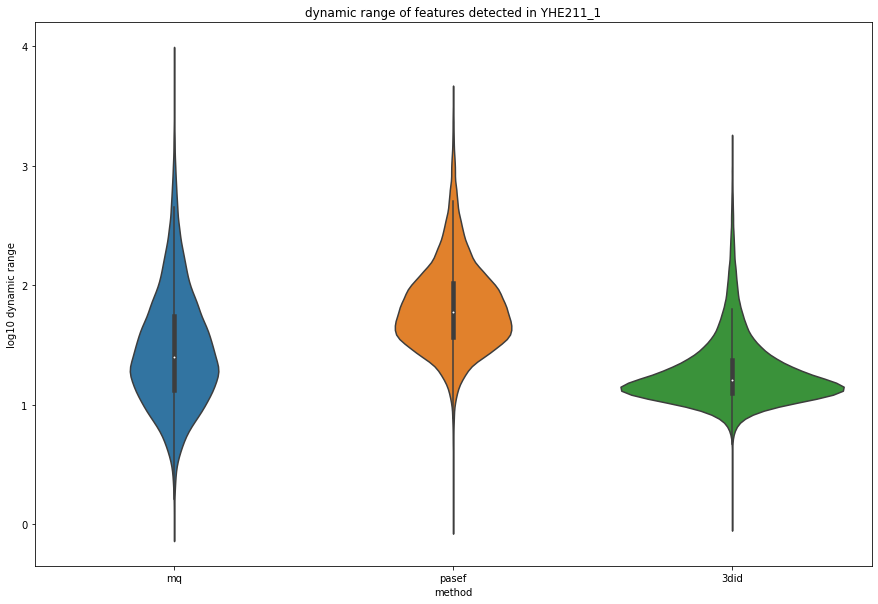

In [47]:
plt.figure(figsize=(15,10))
ax = sns.violinplot(x=intensities_df.method, y=intensities_df.log_intensity_adjusted)
_ = plt.ylabel("log10 dynamic range")
_ = plt.title('dynamic range of features detected in YHE211_1')

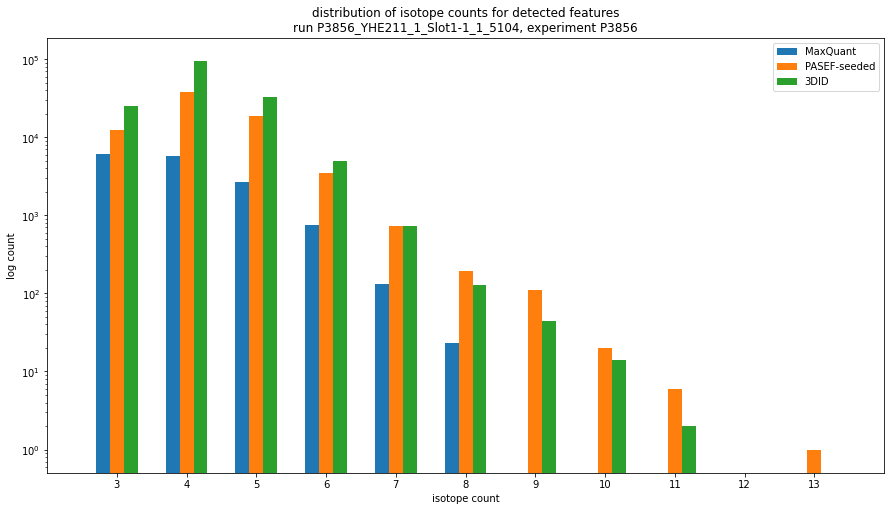

In [48]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

barwidth = 0.2
max_isotope_count = max(features_pasef_df.isotope_count.max(), features_mq_df.isotope_count.max(), features_3did_df.isotope_count.max())

pos1 = [x - barwidth for x in range(max_isotope_count+1)]
pos2 = [x + barwidth for x in pos1]
pos3 = [x + (2*barwidth) for x in pos1]

counts = np.bincount(features_mq_df.isotope_count, minlength=max_isotope_count+1)
ax1.bar(pos1, counts, width=barwidth, align='center', log=True, label='MaxQuant')

counts = np.bincount(features_pasef_df.isotope_count, minlength=max_isotope_count+1)
ax1.bar(pos2, counts, width=barwidth, align='center', log=True, label='PASEF-seeded')

counts = np.bincount(features_3did_df.isotope_count, minlength=max_isotope_count+1)
ax1.bar(pos3, counts, width=barwidth, align='center', log=True, label='3DID')

ax1.set(xticks=range(3,max_isotope_count+1), xlim=[2, max_isotope_count+1])

plt.xlabel('isotope count')
plt.ylabel('log count')
plt.title('distribution of isotope counts for detected features\nrun {}, experiment {}'.format(run_name, experiment_name))

plt.legend()
plt.show()